In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1 --ignore-requires-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph #feel free to use any other library of your choice
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


In [ ]:
# walks = get random walks using BiasedRandomWalk
#experiment with the hyperparamenters 
walks = BiasedRandomWalk(G)
# node: root nodes
# length: hmaximum length of a random walk
# n: number of random walks per root node
# p: Defines (unormalised) probability, 1/p, of returning to source node
# q: Defines (unormalised) probability, 1/q, for moving away from source node
# weighted: for weighted random walks
# seed: random seed fixed for reproducibility
weighted_walks = walks.run(nodes=list(G.nodes()), length=10, n=1, p=0.5, 
    q=2, weighted=True, seed=77)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 2485


In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in weighted_walks ]
model = Word2Vec(str_walks, vector_size = 128, window = 5, min_count = 0, sg = 1, workers = 20, epochs = 10) #check which parameter are important
# The embedding vectors can be retrieved from model.wv using the node ID as key.
print(model.wv["19231"].shape)

(128,)


In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (model.wv.vectors)  
# numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

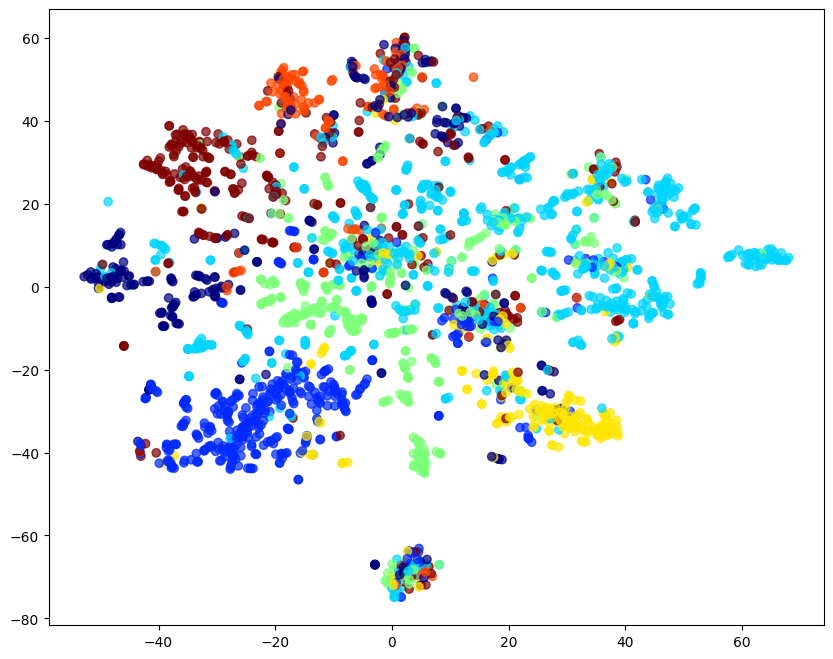

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluateAccuracy(yTest, yPred):
    accuracy = accuracy_score(yTest, yPred)
    f1Score = f1_score(yTest, yPred, average="macro")
    return accuracy, f1Score

def resultDisplay(classify, XTrain, yTrain, XTest, yTest):
  
  # obatin the model with corresponding method
  model = classify().fit(XTrain, yTrain)

  # caculate the predict from XTrain through model
  yPredTrain = model.predict(XTrain)

  # caculate the accuracy and f1 score
  accuracyTrain, fiScoreTrain = evaluateAccuracy(yTrain, yPredTrain)

  # caculate the predict from XTest through model
  yPredTest = model.predict(XTest)

  # caculate the accuracy and f1 score
  accuracyTest, fiScoreTest = evaluateAccuracy(yTest, yPredTest)

  # print the result
  print(f"  * Train Accuracy:{accuracyTrain:.10f}")
  print(f"  * Train F1 Score:{fiScoreTrain:.10f}")
  print(f"  * Test Accuracy :{accuracyTest:.10f}")    
  print(f"  * Test F1 Score :{fiScoreTest:.10f}")


**Node2Vec**


In [ ]:
# import the Three methodologies used in the experiment
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)
# display the shape of the X and y
print(X.shape,y.shape)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# make the classification methodologies' list
classifyMethods = {"LSVCM": LinearSVC, "MLPCM": MLPClassifier, "RFCM": RandomForestClassifier}

for classifierName, classifier in classifyMethods.items():
    
  # print the classification methodology's name
  print(f"{classifierName=}:")

  temp_model = classifier().fit(X_train, y_train)

  resultDisplay(classifier, X_train, y_train, X_test, y_test)

(2485, 128) (2485,)
classifierName='LSVCM':
  * Train Accuracy:0.8008588298
  * Train F1 Score:0.7908519427
  * Test Accuracy :0.7926045016
  * Test F1 Score :0.7800464122
classifierName='MLPCM':


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  * Train Accuracy:0.8631239936
  * Train F1 Score:0.8501853276
  * Test Accuracy :0.8295819936
  * Test F1 Score :0.8118671021
classifierName='RFCM':
  * Train Accuracy:1.0000000000
  * Train F1 Score:1.0000000000
  * Test Accuracy :0.8102893891
  * Test F1 Score :0.7952626526


**Text Feature**

In [ ]:
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

--2023-05-05 20:46:40--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘cora.tgz.1’

cora.tgz.1          100%[===================>] 164.11K  --.-KB/s    in 0.1s    

2023-05-05 20:46:40 (1.60 MB/s) - ‘cora.tgz.1’ saved [168052/168052]



In [ ]:
!tar -xvf  'cora.tgz' 

cora/
cora/README
cora/cora.cites
cora/cora.content


In [ ]:
# the code below obtain the data and the edge of the network
all_data = []
all_edges = []
for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())  

In [ ]:
# obtain the needed dataset
# initialize the list for labels nodes and features of each data
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
 
    elements = data.split('\t')
    if elements[0] in node_ids: 
      labels.append(elements[-1])
      X.append(elements[1:-1])
      nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)

#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)


X shape:  (2485, 1433)

Number of nodes (N):  2485

Number of features (F) of each node:  1433

Categories:  {'Reinforcement_Learning', 'Genetic_Algorithms', 'Rule_Learning', 'Probabilistic_Methods', 'Neural_Networks', 'Case_Based', 'Theory'}

Number of classes:  7


In [ ]:
#TFIDF
from sklearn.feature_extraction.text import TfidfTransformer
#obtiant he TFIDE transformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
#X_tf = []
X_tf =tf_transformer.transform(X)
labels = np.array(labels)

print(X_tf.shape)

(2485, 1433)


In [ ]:
# obtain the train and test dataset
X_train_tf, X_test_tf, y_train_tf, y_test_tf =  train_test_split(X, y, random_state=42)

# make the classification methodologies' list
classifyMethods = {"LSVCM": LinearSVC, "MLPCM": MLPClassifier, "RFCM": RandomForestClassifier}

for classifierName, classifier in classifyMethods.items():
    
  # print the classification methodology's name
  print(f"{classifierName=}:")

  temp_model = classifier().fit(X_train_tf, y_train_tf)

  resultDisplay(classifier, X_train_tf, y_train_tf, X_test_tf, y_test_tf)

classifierName='LSVCM':
  * Train Accuracy:0.9812130972
  * Train F1 Score:0.9832503391
  * Test Accuracy :0.1784565916
  * Test F1 Score :0.1405118297
classifierName='MLPCM':
  * Train Accuracy:0.9951690821
  * Train F1 Score:0.9952453310
  * Test Accuracy :0.1881028939
  * Test F1 Score :0.1337900494
classifierName='RFCM':
  * Train Accuracy:0.9951690821
  * Train F1 Score:0.9952426404
  * Test Accuracy :0.2668810289
  * Test F1 Score :0.1028190498


**Combine the Node2Vec and Text Feacture**

In [ ]:
# Combine
X_train_Combine = np.concatenate((X_train, X_train_tf), axis=1)
X_test_Combine = np.concatenate((X_test, X_test_tf), axis=1)

# make the classification methodologies' list
classifyMethods = {"LSVCM": LinearSVC, "MLPCM": MLPClassifier, "RFCM": RandomForestClassifier}

for classifierName, classifier in classifyMethods.items():
    
  # print the classification methodology's name
  print(f"{classifierName=}:")

  temp_model = classifier().fit(X_train_Combine, y_train)

  resultDisplay(classifier, X_train_Combine, y_train, X_test_Combine, y_test)


classifierName='LSVCM':
  * Train Accuracy:0.9994632313
  * Train F1 Score:0.9994523249
  * Test Accuracy :0.5819935691
  * Test F1 Score :0.5515498573
classifierName='MLPCM':
  * Train Accuracy:1.0000000000
  * Train F1 Score:1.0000000000
  * Test Accuracy :0.5610932476
  * Test F1 Score :0.5262793771
classifierName='RFCM':
  * Train Accuracy:1.0000000000
  * Train F1 Score:1.0000000000
  * Test Accuracy :0.7926045016
  * Test F1 Score :0.7768079189
